# Data Forecasting

The module is in charge of: 
- forecasting the value of temperature in the next X seconds; 
- forecasting the value of humidity in the next X seconds; 
- forecasting the value of the gas sensor in the next X seconds 

(X is defined by users or developers). 

The time-series of the predicted values must be saved on INFLUX and shown on the GRAFANA dashboard as well; e.g. by using two lines for the temperature graph, one related to raw measurements, one to predictions. One or multiple techniques for time-series forecasting can be developed and compared.


## Import Dependencies

In [ ]:
!pip3 install influxdb_client
!pip3 install statsmodels
!pip3 install sklearn
!pip3 install cufflinks
!pip3 install pmdarima
!pip3 install chart-studio

In [21]:
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import matplotlib.pyplot as plt
import chart_studio.plotly as py
import numpy as np
import pandas as pd
import seaborn as sns
import random
from datetime import datetime,timezone
import dateutil.parser
import time
import statsmodels.graphics.tsaplots as tsaplots
from datetime import timedelta
from influxdb_client import InfluxDBClient, Point, WriteOptions
from influxdb_client.client.write_api import SYNCHRONOUS
from influxdb_client.client.write_api import WriteType

## Influx Setting

In [ ]:
INFLUXDB_HOST = os.getenv("INFLUX_HOST")
INFLUXDB_PORT = os.getenv("INFLUX_HOST_PORT")
INFLUXDB_ORG = os.getenv("INFLUX_ORG")
INFLUXDB_TOKEN = os.getenv("INFLUX_TOKEN")
client = InfluxDBClient(url="http://"+INFLUXDB_HOST+":"+INFLUXDB_PORT, token=INFLUXDB_TOKEN, org=INFLUXDB_ORG)

## Influx Query

In [ ]:
buckets = ['temperature']
for bucket in buckets:
    query = 'from(bucket: "' + bucket + '")' \
                ' |> range(start: 2022-09-26T00:00:00.00Z, stop: 2022-09-28T15:50:00.00Z)' \
                ' |> filter(fn: (r) => r["_measurement"] == "val")' \
                ' |> filter(fn: (r) => r["_field"] == "'+bucket+ '")' \
                ' |> aggregateWindow(every: 3m , fn: mean, createEmpty: false)'\
                ' |> yield(name: "mean")'\

    result = client.query_api().query(org=INFLUXDB_ORG, query=query)

,Temperature
count,449.000000
mean,27.829988
std,0.551873
min,23.327273
25%,27.513846
50%,27.979592
75%,28.279687
max,28.500000


In [8]:
data.index = pd.to_datetime(data.index)

In [9]:
data.head()
print(data.shape[0])

449


In [10]:
data.columns = ['value']

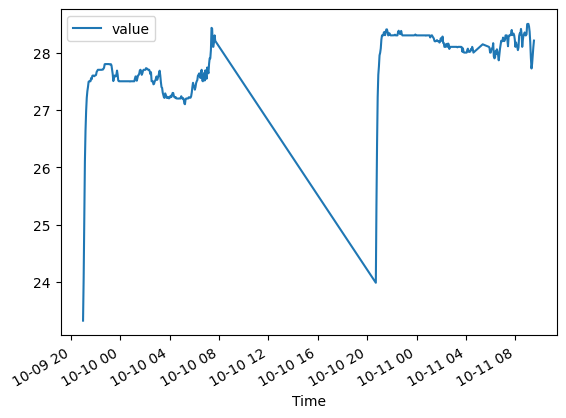

In [11]:
plot_cols = ['value']
plot_features = data[plot_cols]
plot_features.index = data.index
_ = plot_features.plot(subplots=True)


## hyperparameters setting for ARIMA model

In [12]:
# grid search ARIMA parameters for time series
import warnings
from math import sqrt
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
 
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	rmse = sqrt(mean_squared_error(test, predictions))
	return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
 
# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
# evaluate parameters
p_values = [0, 1, 2]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(data.values, p_values, d_values, q_values)

/var/folders/n9/754psrw51dg25ldhmszf6lyh0000gn/T/ipykernel_46062/2653802487.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


ARIMA(0, 0, 0) RMSE=0.428
ARIMA(0, 0, 1) RMSE=0.252
ARIMA(0, 0, 2) RMSE=0.183
ARIMA(0, 1, 0) RMSE=0.069
ARIMA(0, 1, 1) RMSE=0.069
ARIMA(0, 1, 2) RMSE=0.069
ARIMA(0, 2, 0) RMSE=0.089
ARIMA(0, 2, 1) RMSE=0.070
ARIMA(0, 2, 2) RMSE=0.070
ARIMA(1, 0, 0) RMSE=0.072
ARIMA(1, 0, 1) RMSE=0.072
ARIMA(1, 0, 2) RMSE=0.072
ARIMA(1, 1, 0) RMSE=0.069
ARIMA(1, 1, 1) RMSE=0.069
ARIMA(1, 1, 2) RMSE=0.067
ARIMA(1, 2, 0) RMSE=0.082
ARIMA(1, 2, 1) RMSE=0.070
ARIMA(1, 2, 2) RMSE=0.070
ARIMA(2, 0, 0) RMSE=0.072
ARIMA(2, 0, 1) RMSE=0.072
ARIMA(2, 0, 2) RMSE=0.071
ARIMA(2, 1, 0) RMSE=0.069
ARIMA(2, 1, 1) RMSE=0.067
ARIMA(2, 1, 2) RMSE=0.067
ARIMA(2, 2, 0) RMSE=0.080
ARIMA(2, 2, 1) RMSE=0.069
ARIMA(2, 2, 2) RMSE=0.069
Best ARIMA(2, 1, 1) RMSE=0.067


In [13]:

from pmdarima.arima import auto_arima
stepwise_model = auto_arima(data.values, start_p=1, start_q=1,
                          max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.96 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=272.947, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=178.589, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.89 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=273.990, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=137.226, Time=0.51 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=3.03 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.80 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=135.325, Time=0.27 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=176.932, Time=0.05 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=2.42 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.61 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=137.201, Time=0.39 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=130.924, Time=0.98 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=168.140, Time=

## Evaluation ARIMA model

In [37]:
def result_to_dataframe(result):
    raw = []
    for table in result:
        for record in table.records:
            raw.append((record.get_time(), record.get_value()))
    return pd.DataFrame(raw, columns=['ds','y'], index=None)
    
buckets = ['temperature']
for bucket in buckets:
    query = 'from(bucket: "' + bucket + '")' \
                ' |> range(start: 2022-09-26T00:00:00.00Z, stop: 2022-09-28T15:50:00.00Z)' \
                ' |> filter(fn: (r) => r["_measurement"] == "val")' \
                ' |> filter(fn: (r) => r["_field"] == "'+bucket+ '")' \
                ' |> aggregateWindow(every: 3m , fn: mean, createEmpty: false)'\
                ' |> yield(name: "mean")'\

    result = client.query_api().query(org=INFLUXDB_ORG, query=query)

    print(result)
    # Convert the results to dataframe
    df = result_to_dataframe(result)
    print(df)
    df['ds'] = df['ds'].dt.tz_localize(None)

    # split into train and test sets
    nrows = (len(df.values))
    splitPoint = int (nrows * 0.60)
    train = df['y'] [:splitPoint]
    test = df['y'] [splitPoint:]
    history = [x for x in train]
    predictions = list()
    l = list()

    for x in history:
        l.append(x)
    for t in range(len(test)):
        print(t)
    # walk-forward validation
    for t in range(len(test)):
        model = ARIMA(history, order=(2,1,1))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        l.append(yhat)
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        print('predicted=%f, expected=%f' % (yhat, obs))
    # evaluate forecasts
    rmse = sqrt(mean_squared_error(test, predictions))
    print('Test RMSE: %.3f' % rmse)


    future_forecast1 = pd.DataFrame(predictions,index = test.index ,columns = ['Predicted values'])
    future_forecast2 = pd.DataFrame(l,index = df.index,  columns = ['Predicted values'])
    future_forecast1
    colors = ["blue","red"]

    cf.go_offline()
    pd.concat([future_forecast1,test],axis=1).iplot(color = colors)
    pd.concat([future_forecast2,train],axis=1).iplot(color = colors)

/var/folders/n9/754psrw51dg25ldhmszf6lyh0000gn/T/ipykernel_49293/2024634217.py:3: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



KeyError: 0

In [ ]:
future_forecast1.reset_index(inplace=True)
future_forecast1["Time"]

In [29]:
#buckets = [ 'temperature', 'humidity', 'gas']
bucket = 'temperature'
lines = [str(future_forecast1["Predicted values"][d]) for d in range(len(future_forecast1))]
print(lines)
future_forecast1.reset_index(inplace=True)

future_forecast1['Time'] = pd.to_datetime(future_forecast1['Time'])
future_forecast1['Time'] = future_forecast1['Time'].dt.tz_localize(None)
future_forecast1['Time']
lines = ['val,prediction=yes,clientId=' + str("diubi-esp-32")+",lat=999,lng=999"+ " " + bucket + '=' + str(future_forecast1["Predicted values"][d])
                                    + ' ' + str(int(time.mktime(future_forecast1['Time'][d].timetuple())) + 3600*2) + "000000000" for d in range(len(future_forecast1))]
write_client = client.write_api(write_options=WriteOptions(batch_size=1000, flush_interval=10_000,
                                                            jitter_interval=2_000, retry_interval=5_000, write_type=WriteType.synchronous))
write_client.write(bucket, INFLUXDB_ORG, lines)

['28.30059826949105', '28.300501169030294', '28.300419912377293', '28.300351568102126', '28.300294036334943', '28.30024664325173', '28.300206986313537', '28.300173632650637', '28.30014546664556', '28.30012168073786', '28.304970732567508', '28.314906801183906', '28.29886753815069', '28.30035504062549', '28.300297473189286', '28.300249262498276', '28.30020878014579', '28.300175203383088', '28.30014666088803', '28.300122864507095', '28.30010317252212', '28.300086417660374', '28.30007253400407', '28.30006077661865', '28.300050929805703', '28.300042679015814', '28.30003586363118', '28.30003008511134', '28.295525579309995', '28.300399528298584', '28.299949260137915', '28.29995741980606', '28.299964336749724', '28.299970196879883', '28.299974903586982', '28.264404338337982', '28.292313190409935', '28.30033955265716', '28.299372001124834', '28.276272869664556', '28.26492621360139', '28.243576039909836', '28.206332543619048', '28.2027634302835', '28.208214988886947', '28.206615511179113', '28.2